## **1. Librerias**

In [2]:
import pandas as pd
import numpy as np
import umap
import umap.plot
import gudhi as gd
import matplotlib.pyplot as plt
#from umap import UMAPTransformer
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import scipy.cluster.hierarchy as sch
import requests

In [3]:
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo import draw


## **2. Funciones**

In [4]:
##Calcula la secuencia media a partiar de secuencias
def compute_median_sequence(a, b, c):
    median = ""
    for i in range(len(a)):
        counts = {'0': 0, '1': 0}
        counts[a[i]] += 1
        counts[b[i]] += 1
        counts[c[i]] += 1
        majority = max(counts, key=counts.get)
        median += majority
    return median
##Calcula la secuencia media a partiar de vectores
def compute_median_vector(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    median = np.zeros_like(a)
    for i in range(len(a)):
        counts = np.bincount([a[i], b[i], c[i]])
        majority = np.argmax(counts)
        median[i] = majority
    return median.tolist()
##Crea un nuevo diccionario, a partir del anterior, y le agrega los puntos medios
def process_dict_elements(dictionary):
    keys = list(dictionary.keys())
    result = {}
    for combination in combinations(keys, 3):
        a, b, c = combination
        median = compute_median_vector(dictionary[a], dictionary[b], dictionary[c])
        new_key = f"{a}_{b}_{c}"  # Clave nueva basada en la combinación de claves originales
        result[new_key] = median
    dictionary.update(result)  # Agregar las medianas calculadas al diccionario original
    return dictionary
##calcula la matriz de distancia a partir de un dataframe
def distancia(df,metrica='hamming'):
    distances = pdist(df.values.T, metric=metrica)
    distance_matrix = squareform(distances)
    return(distance_matrix)
##Calcula el comprejo de Rips y regresa la persistencia.
def complejo(distance_matrix):
# Create the simplicial complex from the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
# Compute persistence
    persistence = simplex_tree.persistence()
    return(persistence)

In [5]:
def crear_archivo_txt(diccionario):
    with open('genomas.fa', 'w') as archivo:
        for clave, valores in diccionario.items():
            archivo.write(">" + clave + "\n")  # Escribe la clave con ">" al inicio
            cadena_valores = ''.join(str(valor) for valor in valores)  # Concatena los elementos de la lista
            archivo.write(cadena_valores + "\n")  # Escribe la cadena de valores


In [6]:
def hamming_distance(string1: str, string2: str) -> int:
    """Return the Hamming distance between two strings."""
    if len(string1) != len(string2):
        raise ValueException("Strings must be of equal length.")
    dist_counter = 0
    for n in range(len(string1)):
        if string1[n] != string2[n]:
            dist_counter += 1
    return dist_counter

In [7]:
def plot_cladogram(data):
    # Convert the dictionary into a matrix
    matrix = np.array([list(value) for value in data.values()])

    # Calculate the distance matrix
    dist_matrix = sch.distance.pdist(matrix)

    # Perform hierarchical clustering
    linkage_matrix = sch.linkage(dist_matrix)

    # Plot the dendrogram
    plt.figure(figsize=(8, 6))
    dendrogram = sch.dendrogram(linkage_matrix, labels=list(data.keys()), orientation='right')

    # Adjust the margins and labels of the x-axis
    plt.subplots_adjust(bottom=0.1)
    plt.xticks(rotation='vertical')

    # Show the cladogram
    plt.show()


## **3. Ejemplos**
### **3.1. Libro**


In [6]:
data = {'Genoma1': [0, 0],
        'Genoma2': [1, 0],
        'Genoma3': [0, 1],
        'Genoma4': [1, 1]}
df_libro = pd.DataFrame(data, index=['Gen1', 'Gen2'])
df_libro

,Genoma1,Genoma2,Genoma3,Genoma4
Gen1,0,1,0,1
Gen2,0,0,1,1


In [7]:
distancia(df_libro)

array([[0. , 0.5, 0.5, 1. ],
       [0.5, 0. , 1. , 0.5],
       [0.5, 1. , 0. , 0.5],
       [1. , 0.5, 0.5, 0. ]])

In [8]:
matrix_dintancia_libro=distancia(df_libro)
persistence_libro=complejo(matrix_dintancia_libro)

usetex mode requires dvipng.


<AxesSubplot:title={'center':'Persistence barcode'}>

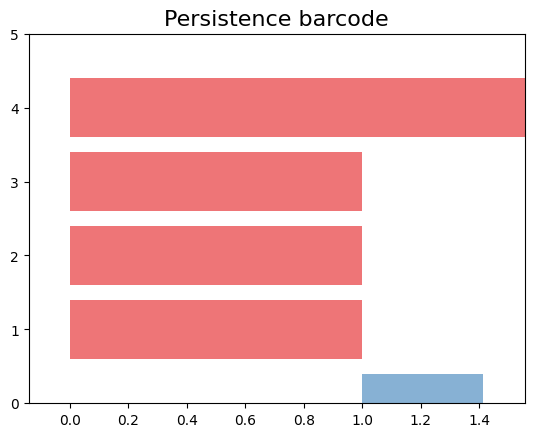

In [9]:
gd.plot_persistence_barcode(persistence_libro)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

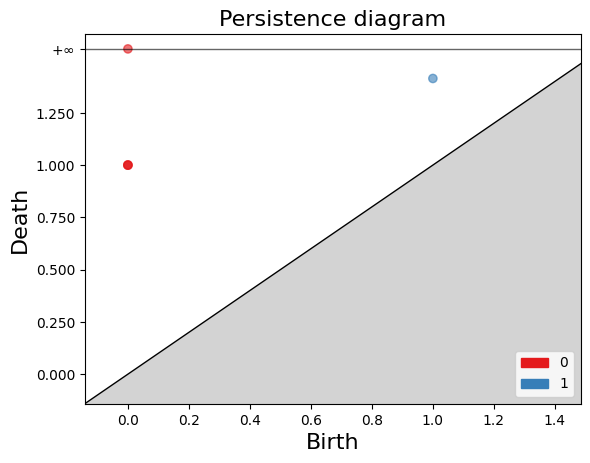

In [10]:
gd.plot_persistence_diagram(persistence_libro,legend=True)

### **3.2. Genes**

In [11]:
df = pd.read_csv("/home/shaday/GIT/pangenomics/files/familias_minis.csv", index_col=0)
df_filled = df.fillna(0)
df=df_filled.replace(to_replace=r'.+', value=1, regex=True)
df

,g_A909,g_2603V,g_515,g_NEM316
A909|MGIDGNCP_01408,1,1,1,1
A909|MGIDGNCP_00096,1,1,1,1
A909|MGIDGNCP_01343,1,0,0,1
A909|MGIDGNCP_01221,1,0,1,0
A909|MGIDGNCP_01268,1,1,1,1
A909|MGIDGNCP_00580,1,1,1,1
A909|MGIDGNCP_00352,1,1,1,1
A909|MGIDGNCP_00064,1,1,1,1
A909|MGIDGNCP_00627,1,0,0,0
A909|MGIDGNCP_01082,1,1,0,0


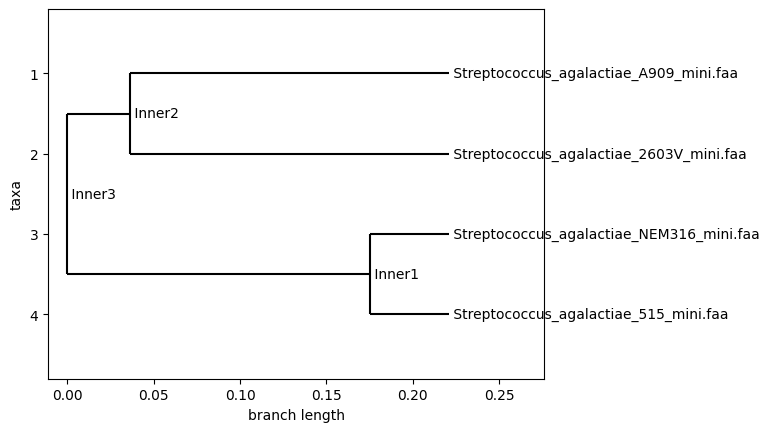

In [50]:
url = "https://raw.githubusercontent.com/paumayell/pangenomics/gh-pages/files/minigenomes_allig.fasta"
response = requests.get(url)
response.raise_for_status()  # Check if any errors occurred during the download
# Save the downloaded content to a local file
with open("minigenomes_allig.fasta", "wb") as file:
    file.write(response.content)
sequences = list(SeqIO.parse("minigenomes_allig.fasta", "fasta"))
# Rest of your code that uses the sequences
alignment = MultipleSeqAlignment(sequences)
# Calculate the distance matrix
calculator = DistanceCalculator('identity')
distance_matrix = calculator.get_distance(alignment)

# Build the UPGMA tree
constructor = DistanceTreeConstructor()
upgma_tree = constructor.upgma(distance_matrix)

# Draw the UPGMA tree
draw(upgma_tree)


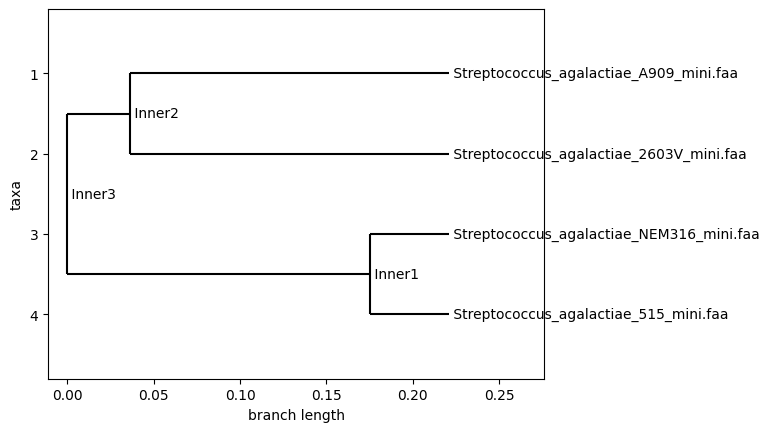

In [16]:
# Leer el archivo de secuencias en formato FASTA
#sequences = list(SeqIO.parse("/home/shaday/GIT/temp/all_allig.fasta", "fasta"))
#sequences
alignment = MultipleSeqAlignment(sequences)
# Calcular la matriz de distancias
calculator = DistanceCalculator('identity')
distance_matrix = calculator.get_distance(alignment)

# Construir el árbol UPGMA
constructor = DistanceTreeConstructor()
upgma_tree = constructor.upgma(distance_matrix)

# Dibujar el árbol UPGMA
draw(upgma_tree)

# Construir el árbol NJ
#nj_tree = constructor.nj(distance_matrix)

# Dibujar el árbol NJ
#draw(nj_tree)

In [51]:
df_primera=df.iloc[:4,:]


<AxesSubplot:title={'center':'Persistence barcode'}>

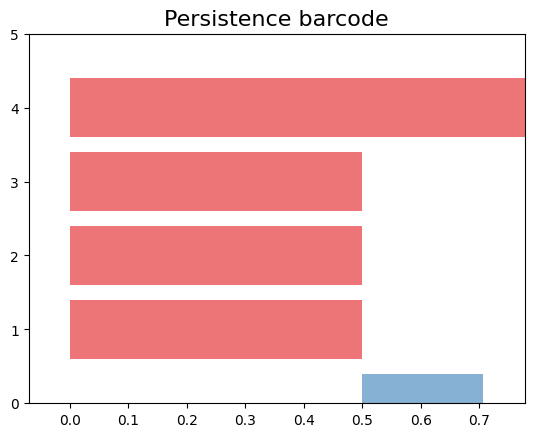

In [52]:
matrix_dintancia_genes_primera=distancia(df_primera)
persistence_genes_primera=complejo(matrix_dintancia_genes_primera)
gd.plot_persistence_barcode(persistence_genes_primera)

In [53]:
df_segunda=df.iloc[-4:,:]
df_segunda

,g_A909,g_2603V,g_515,g_NEM316
A909|MGIDGNCP_00405,1,1,1,1
2603V|GBPINHCM_00748,0,1,0,0
2603V|GBPINHCM_01226,0,1,0,0
515|LHMFJANI_01625,0,0,1,1


<AxesSubplot:title={'center':'Persistence barcode'}>

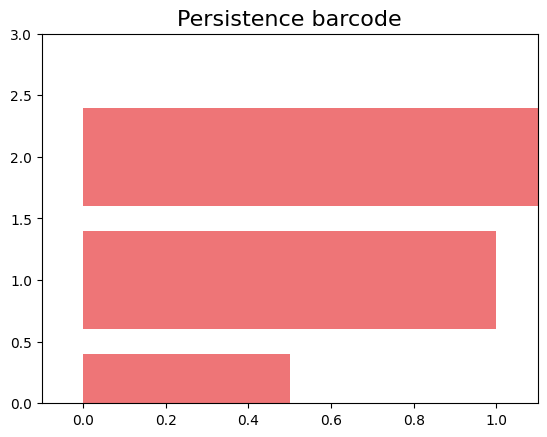

In [54]:
matrix_dintancia_genes_segunda=distancia(df_segunda)
persistence_genes_segunda=complejo(matrix_dintancia_genes_segunda)
gd.plot_persistence_barcode(persistence_genes_segunda)

In [27]:
#crear un diccionario de cada genoma convertivo a "0" y "1" de presencia y auscnia de genes
genomas = {}
for columna in df.columns:
    genomas[columna] = list(np.array(df[columna]))
genomas

{'g_A909': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
 'g_2603V': [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
 'g_515': [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
 'g_NEM316': [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]}

In [12]:
#Añadir una resistencia
#c=[1,0,0,1]
#df.loc['anti']=c
#df=df.iloc[-2:]
#df

In [25]:
matrix_dintancia_genes=distancia(df)
persistence_genes=complejo(matrix_dintancia_genes)

<AxesSubplot:title={'center':'Persistence barcode'}>

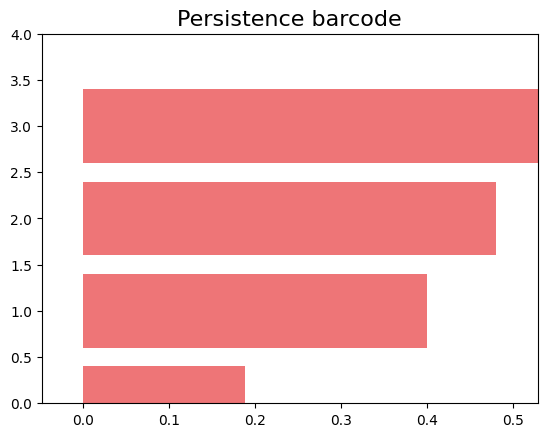

In [26]:
gd.plot_persistence_barcode(persistence_genes)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

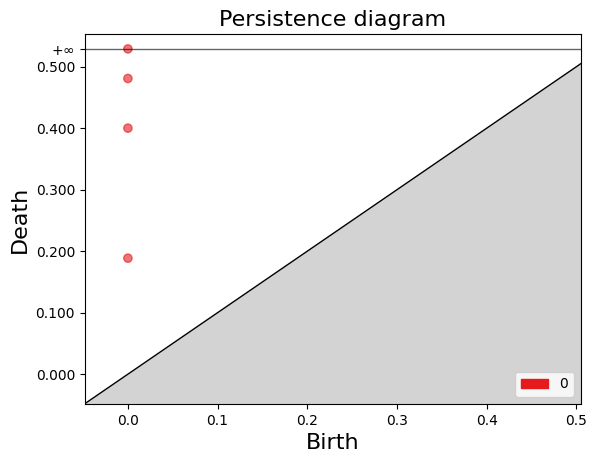

In [15]:
gd.plot_persistence_diagram(persistence_genes,legend=True)


### **3.3 Añadiendo las medianas**

In [30]:
genomas_mediam=process_dict_elements(genomas)
genomas_mediam

{'g_A909': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
 'g_2603V': [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
 'g_515': [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
 'g_NEM316': [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
 'g_A909_g_2603V_g_515': [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
 'g_A909_g_2603V_g_NEM316': [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
 'g_A909_g_515_g_NEM316': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
 'g_2603V_g_515_g_NEM316': [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]}

In [45]:
df_mediam = pd.DataFrame.from_dict(genomas_mediam)
df_mediam.iloc[:4,5:]

,g_A909_g_2603V_g_NEM316,g_A909_g_515_g_NEM316,g_2603V_g_515_g_NEM316
0,1,1,1
1,1,1,1
2,1,1,0
3,0,1,0


In [46]:
matrix_dintancia_extendida=distancia(df_mediam)
persistence_extendida=complejo(matrix_dintancia_extendida)
matrix_dintancia_extendida

array([[0.        , 0.33333333, 0.26666667, 0.26666667, 0.13333333,
        0.13333333, 0.2       , 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333, 0.2       ,
        0.2       , 0.4       , 0.26666667],
       [0.26666667, 0.33333333, 0.        , 0.13333333, 0.13333333,
        0.26666667, 0.06666667, 0.06666667],
       [0.26666667, 0.33333333, 0.13333333, 0.        , 0.26666667,
        0.13333333, 0.06666667, 0.06666667],
       [0.13333333, 0.2       , 0.13333333, 0.26666667, 0.        ,
        0.13333333, 0.2       , 0.2       ],
       [0.13333333, 0.2       , 0.26666667, 0.13333333, 0.13333333,
        0.        , 0.2       , 0.2       ],
       [0.2       , 0.4       , 0.06666667, 0.06666667, 0.2       ,
        0.2       , 0.        , 0.13333333],
       [0.33333333, 0.26666667, 0.06666667, 0.06666667, 0.2       ,
        0.2       , 0.13333333, 0.        ]])

<AxesSubplot:title={'center':'Persistence barcode'}>

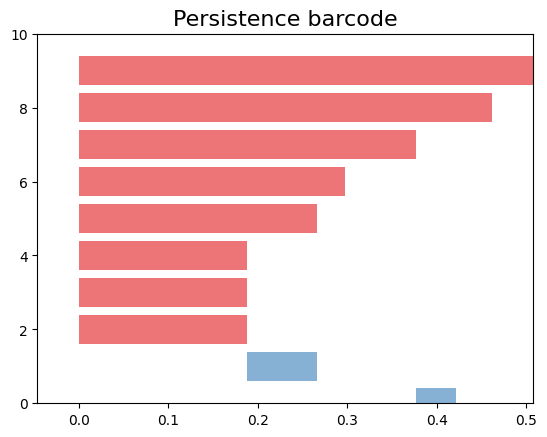

In [47]:
gd.plot_persistence_barcode(persistence_extendida)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

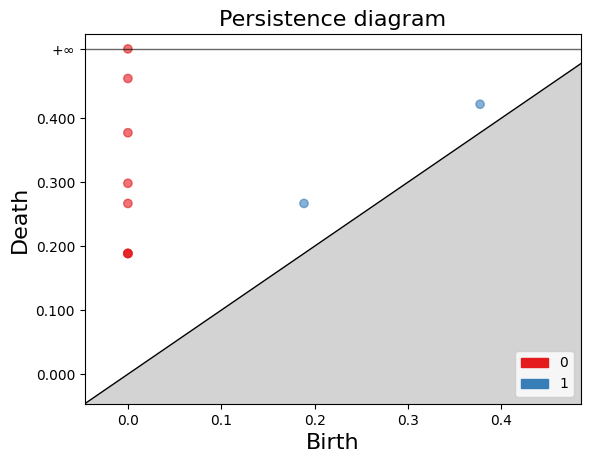

In [48]:
gd.plot_persistence_diagram(persistence_extendida,legend=True)

In [21]:
#crear_archivo_txt(genomas)

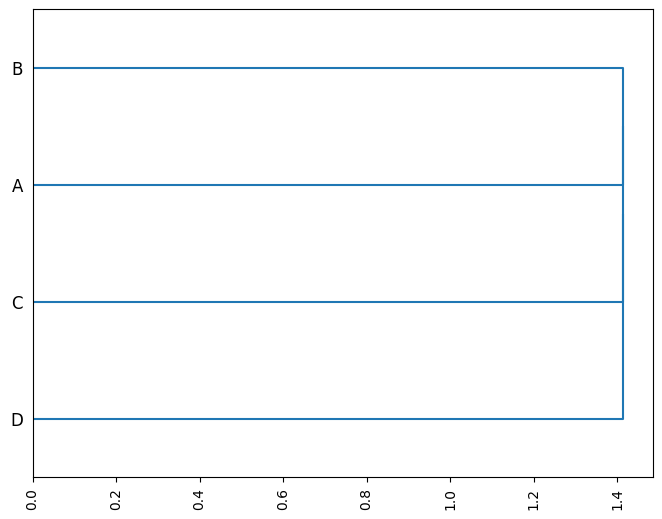

In [25]:
# Example dictionary with 1's and 0's
data = {
    'A': [1, 0, 1, 0],
    'B': [0, 1, 1, 0],
    'C': [0, 0, 1, 1],
    'D': [1, 1, 0, 0]
}

# Generate the cladogram
plot_cladogram(data)


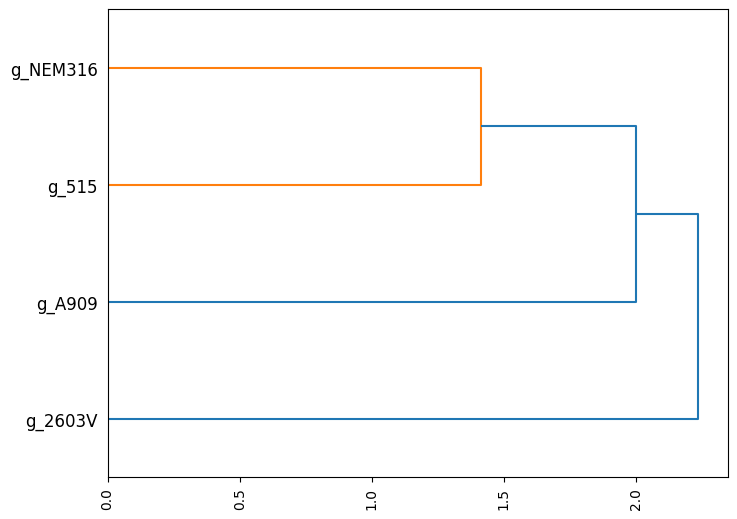

In [34]:
plot_cladogram(genomas)

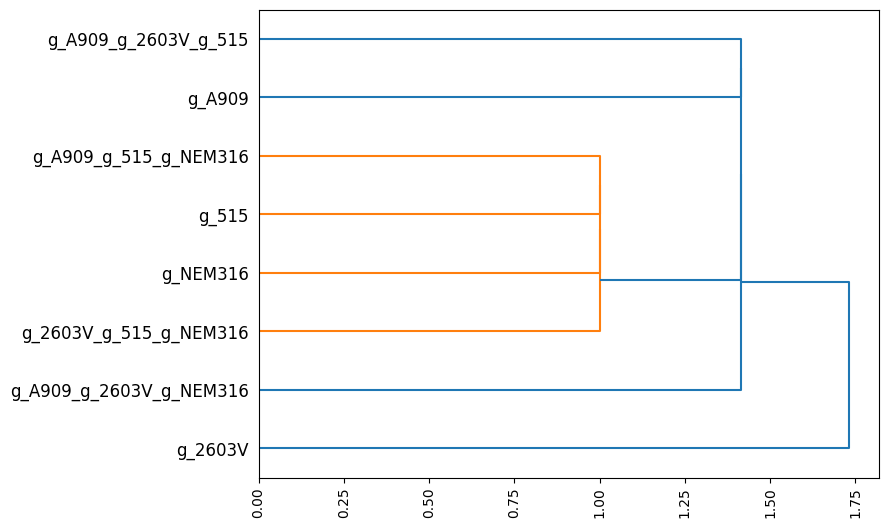

In [32]:
plot_cladogram(genomas)

In [41]:


df = pd.read_csv("/home/shaday/GIT/cambda2023/Resistencia/data/230622_AMR_mysterious_ETBC_all_nelly.csv", index_col=0)
df2=df.iloc[-10:,3:]
df2

,rpos,ARO:3000361,espy1,drad,allr,feob,kphs_23120,gspj,ARO:3002714,ARO:3002796,...,ARO:3003838,ARO:3002132,ARO:3003577,parc,ARO:3001115,gnd,ARO:3002357,ARO:3000833,ompk35,hcp1tssd1
ID,,,,,,,,,,,,,,,,,,,,,
BAL_En,0,0.0,0,0,0,0,0,0,0.0,0.0,...,0,0.0,0,0,0.0,0,0.0,0,0,0
DEN_En,0,0.0,0,0,0,0,0,0,0.0,0.0,...,0,0.0,0,0,0.0,0,0.0,0,0,0
MIN_En,0,0.0,0,0,0,0,0,0,0.0,0.0,...,0,0.0,0,0,0.0,0,0.0,0,0,0
NYC_En,1,0.0,0,0,0,0,0,0,0.0,0.0,...,1,0.0,1,1,0.0,1,0.0,1,1,0
NYC_Es,1,0.0,0,0,0,0,0,0,0.0,0.0,...,1,0.0,1,0,0.0,1,0.0,1,0,0
NYC_Kl,1,0.0,0,0,0,0,0,0,0.0,0.0,...,1,0.0,1,1,0.0,0,0.0,1,1,0
SAC_En,0,0.0,0,0,0,0,0,0,0.0,0.0,...,0,0.0,0,0,0.0,0,0.0,0,0,0
DEN_Es,0,0.0,0,0,0,0,0,0,0.0,0.0,...,0,0.0,0,0,0.0,0,0.0,0,0,0
DEN_Kl,0,0.0,0,0,0,0,0,0,0.0,0.0,...,0,0.0,0,0,0.0,0,0.0,0,0,0


In [42]:
df2=df2.T

In [44]:
df2=df2.astype(int)
df2

ID,BAL_En,DEN_En,MIN_En,NYC_En,NYC_Es,NYC_Kl,SAC_En,DEN_Es,DEN_Kl,SAN_En
rpos,0,0,0,1,1,1,0,0,0,0
ARO:3000361,0,0,0,0,0,0,0,0,0,0
espy1,0,0,0,0,0,0,0,0,0,0
drad,0,0,0,0,0,0,0,0,0,0
allr,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
gnd,0,0,0,1,1,0,0,0,0,0
ARO:3002357,0,0,0,0,0,0,0,0,0,0
ARO:3000833,0,0,0,1,1,1,0,0,0,0
ompk35,0,0,0,1,0,1,0,0,0,0


In [50]:
genomas_id = {}
for columna in df2.columns:
    genomas_id[columna] = list(np.array(df2[columna]))
genomas_id

{'BAL_En': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,


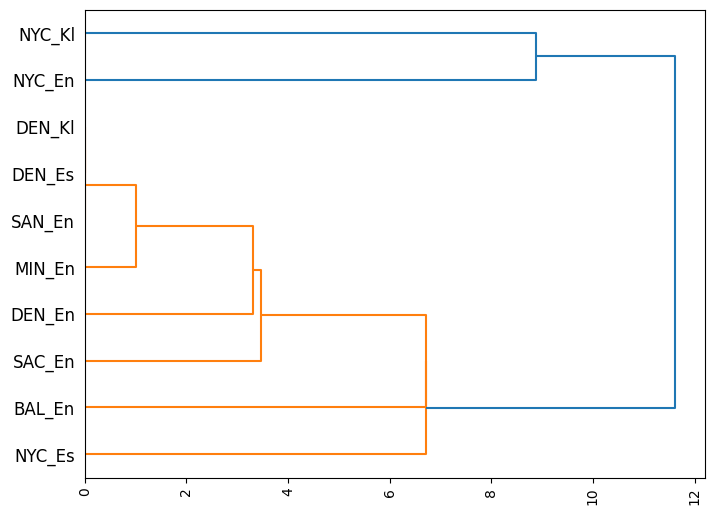

In [51]:
plot_cladogram(genomas_id)

In [35]:
genomas_id["DEN_Kl"]
suma =0
for i in genomas_id["DEN_Kl"]:
    suma=i + suma
suma

0.0

In [47]:
genomas_id_mediam=process_dict_elements(genomas_id)
genomas_id_mediam

{'BAL_En': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,


In [48]:
df_mediam = pd.DataFrame.from_dict(genomas_id_mediam)
matrix_dintancia_extendida=distancia(df_mediam)
persistence_extendida=complejo(matrix_dintancia_extendida)

usetex mode requires dvipng.


<AxesSubplot:title={'center':'Persistence barcode'}>

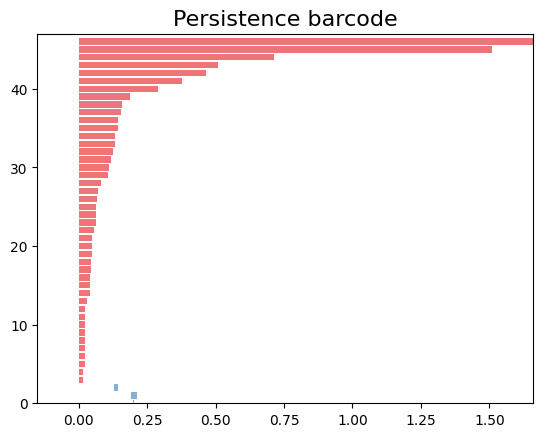

In [39]:
gd.plot_persistence_barcode(persistence_extendida)

In [52]:
crear_archivo_txt(genomas_id)